In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import scipy.io
import scipy as sp
import theano.tensor as th
from scipy.stats import pearsonr

In [3]:
def removeOutliers(x, outlierConstant):
    a = np.array(x)
    upper_quartile = np.percentile(a, 75)
    lower_quartile = np.percentile(a, 25)
    IQR = (upper_quartile - lower_quartile) * outlierConstant
    quartileSet = (lower_quartile - IQR, upper_quartile + IQR)
    
    result = a[np.where((a >= quartileSet[0]) & (a <= quartileSet[1]))]
    
    return np.array(result.tolist())

In [4]:
phantom_data=scipy.io.loadmat('scanner data/Scanner_7TMAGNETOM_MGH.mat')

In [5]:
phantom_data

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Wed Jan 20 18:25:15 2021',
 '__version__': '1.0',
 '__globals__': [],
 'ground_truth': array([[4935.36259766, 4922.47494555, 4944.89076902, ..., 4934.34120353,
         4896.08027526, 4859.11431807],
        [5018.05396003, 5018.81081813, 5016.90585028, ..., 5018.1406931 ,
         5018.38796448, 5014.23143185],
        [5024.01350159, 5018.30457277, 5030.1341616 , ..., 5023.46572726,
         5012.42748793, 5013.2013953 ],
        ...,
        [6429.6154001 , 6389.40709126, 6366.65794541, ..., 6334.94814964,
         6372.58978653, 6348.72196741],
        [6319.37038359, 6371.4297444 , 6399.50661225, ..., 6430.99846826,
         6392.47730672, 6418.9571037 ],
        [6527.34966562, 6472.57530811, 6436.58725652, ..., 6389.78671612,
         6445.66382761, 6410.27705319]]),
 'measured': array([[4836.30580266, 4872.49038494, 4874.6743376 , ..., 4823.48922708,
         4881.29792951, 4849.10600232],
        [4998.10848429,

In [6]:
phantom_data_sd=scipy.io.loadmat('scanner data/Scanner_7TMAGNETOM_MGH_SDs.mat')
phantom_data_sd

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Wed Jan 20 18:25:26 2021',
 '__version__': '1.0',
 '__globals__': [],
 'std_dev': array([[45.78140504, 49.09984837, 47.94630458, ..., 68.09821679,
         74.79670297, 75.13395103]])}

In [7]:
gt = phantom_data["ground_truth"]
fmri = phantom_data["measured"]
static_std = phantom_data_sd['std_dev'][0]
print(gt.shape,fmri.shape,gt.shape)

(12745, 600) (12745, 600) (12745, 600)


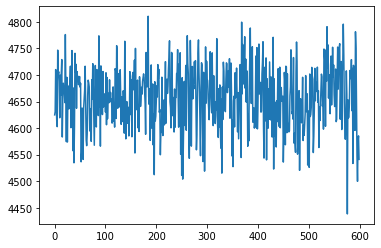

In [8]:
plt.plot(fmri[800])

In [9]:
#split up the sessions.  For Skyra the sessions are 4425,4648,3672 voxels
s1,s2,s3 = 4425,4648,3672
gt1 = gt[:s1]
gt2 = gt[s1:s1+s2]
gt3 = gt[s1+s2:]
fmri1 = fmri[:s1]
fmri2 = fmri[s1:s1+s2]
fmri3 = fmri[s1+s2:]
static_std1 = static_std[:s1]
static_std2 = static_std[s1:s1+s2]
static_std3 = static_std[s1+s2:]

#just checking the length
print(gt1.shape,gt2.shape,gt3.shape)

(4425, 600) (4648, 600) (3672, 600)


4686.453137290294 4880.829662551472 6073.999003881775
(12745, 600) (12745, 600) (12745,)


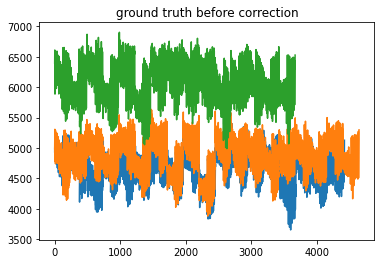

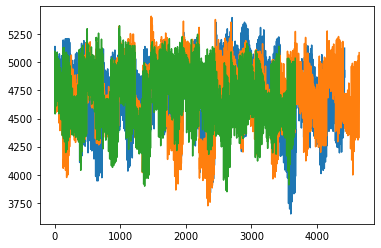

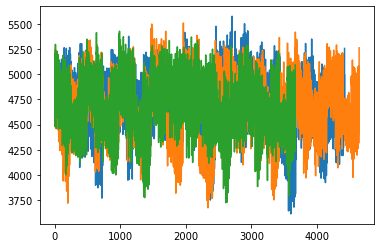

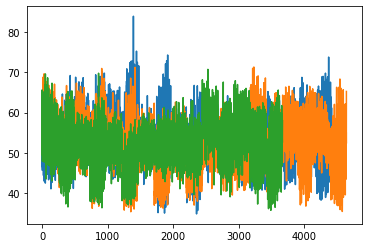

In [10]:
# lets correct for different amplification for the three sessions
plt.figure()
plt.plot(gt1.T[0])
plt.plot(gt2.T[0])
plt.plot(gt3.T[0])
plt.title("ground truth before correction")
print(gt1.T[0].mean(),gt2.T[0].mean(),gt3.T[0].mean())
#lets get them all to the same level
gt1_norm = gt1
gt2_norm = gt2*gt1.T[0].mean()/gt2.T[0].mean()
gt3_norm = gt3*gt1.T[0].mean()/gt3.T[0].mean()

plt.figure()
plt.plot(gt1_norm.T[0])
plt.plot(gt2_norm.T[0])
plt.plot(gt3_norm.T[0])

# now correct the fmri signal
fmri1_norm = fmri1
fmri2_norm = fmri2*gt1.T[0].mean()/gt2.T[0].mean()
fmri3_norm = fmri3*gt1.T[0].mean()/gt3.T[0].mean()

plt.figure()
plt.plot(fmri1_norm.T[0])
plt.plot(fmri2_norm.T[0])
plt.plot(fmri3_norm.T[0])

static_std1_norm = static_std1
static_std2_norm = static_std2*gt1.T[0].mean()/gt2.T[0].mean()
static_std3_norm = static_std3*gt1.T[0].mean()/gt3.T[0].mean()

plt.figure()
plt.plot(static_std1_norm.T)
plt.plot(static_std2_norm.T)
plt.plot(static_std3_norm.T)

# lets put everything together
gt_norm = np.vstack((gt1_norm,gt2_norm,gt3_norm))
fmri_norm = np.vstack((fmri1_norm,fmri2_norm,fmri3_norm))
static_std_norm = np.concatenate((static_std1_norm,static_std2_norm,static_std3_norm))
print(gt_norm.shape,fmri_norm.shape,static_std_norm.shape)

In [11]:
# lets see how the standard deviations compare
gt_std = np.std(gt_norm,axis=1)
fmri_std = np.std(fmri_norm,axis=1)
print(fmri_std.shape,gt_std.shape)
noise_std = np.std((fmri_norm-gt_norm),axis=1)
print (noise_std.mean(),fmri_std.mean(),gt_std.mean(),static_std_norm.mean())
print(np.sqrt(gt_std.mean()**2+static_std.mean()**2))
print("Scanner instability percent:",(noise_std.mean()**2-static_std.mean()**2)/static_std.mean()**2)

(12745,) (12745,)
61.077806605929936 63.51942764765804 29.601027945191404 52.444752112833136
64.8227927319814
Scanner instability percent: 0.12169344821515492


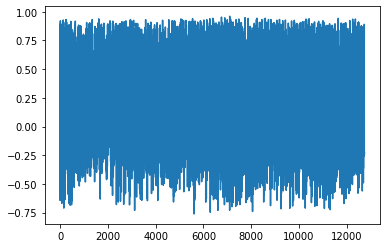

In [12]:
fmri_gt_pearsonr = [pearsonr(f,g)[0] for f,g in zip(fmri_norm,gt_norm)]
fmri_gt_pearsonr = np.array(fmri_gt_pearsonr)
plt.plot(fmri_gt_pearsonr)

(array([  99.,  334.,  875., 1572., 2105., 2274., 1905., 1383., 1246.,
         952.]),
 array([-0.76107999, -0.5889467 , -0.41681341, -0.24468013, -0.07254684,
         0.09958645,  0.27171973,  0.44385302,  0.61598631,  0.78811959,
         0.96025288]),
 <BarContainer object of 10 artists>)

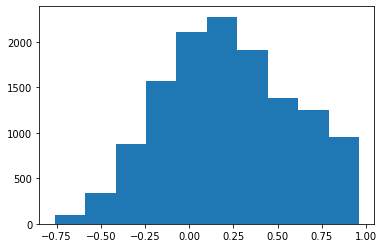

In [13]:
plt.hist(fmri_gt_pearsonr)

(array([2.000e+00, 1.000e+00, 7.000e+00, 1.500e+01, 4.100e+01, 6.700e+01,
        1.540e+02, 2.460e+02, 4.080e+02, 6.790e+02, 9.760e+02, 1.173e+03,
        1.463e+03, 1.485e+03, 1.478e+03, 1.303e+03, 9.980e+02, 7.500e+02,
        5.480e+02, 3.860e+02, 2.270e+02, 1.550e+02, 8.300e+01, 4.300e+01,
        3.300e+01, 8.000e+00, 1.000e+01, 4.000e+00, 1.000e+00, 1.000e+00]),
 array([-292.59272417, -270.71900169, -248.84527921, -226.97155673,
        -205.09783426, -183.22411178, -161.3503893 , -139.47666682,
        -117.60294434,  -95.72922187,  -73.85549939,  -51.98177691,
         -30.10805443,   -8.23433195,   13.63939052,   35.513113  ,
          57.38683548,   79.26055796,  101.13428044,  123.00800291,
         144.88172539,  166.75544787,  188.62917035,  210.50289283,
         232.3766153 ,  254.25033778,  276.12406026,  297.99778274,
         319.87150522,  341.74522769,  363.61895017]),
 <BarContainer object of 30 artists>)

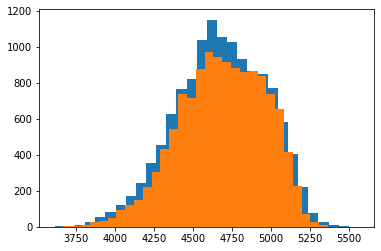

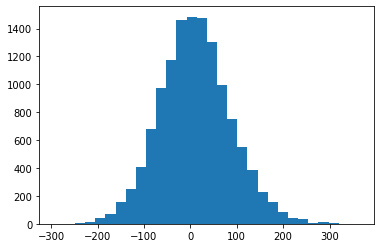

In [14]:
gt_mean = np.mean(gt_norm,axis=1)
fmri_mean = np.mean(fmri_norm,axis=1)
gt_std = np.std(gt_norm,axis=1)
fmri_std = np.std(fmri_norm,axis=1)
fmri_minus_gt = gt_mean-fmri_mean
plt.figure()
plt.hist(fmri_mean,bins=30)
plt.hist(gt_mean,bins=30)
plt.figure()
plt.hist(fmri_minus_gt,bins=30)

In [16]:
gt_skew = sp.stats.skew(gt_norm,axis=1)
fmri_skew = sp.stats.skew(fmri_norm,axis=1)

gt_nooutliers = removeOutliers(gt_skew,1.5)
fmri_nooutliers = removeOutliers(fmri_skew,4.0)
print(len(gt_skew)-len(gt_nooutliers),len(fmri_skew)-len(fmri_nooutliers))

skew_idx = np.argsort(gt_nooutliers)

69 196


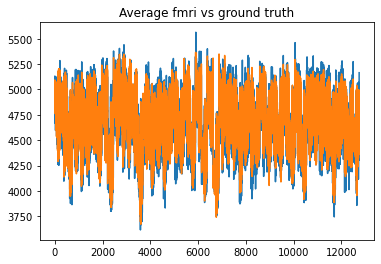

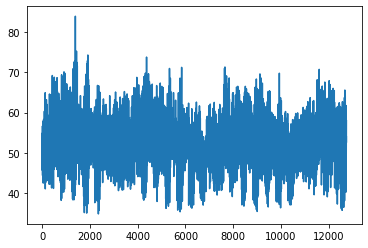

In [17]:
# lets see whether the thermal noise is independent of the intensity level
plt.figure()
plt.plot(fmri_mean)
plt.plot(gt_mean)
plt.title("Average fmri vs ground truth")

plt.figure()
plt.plot(static_std_norm)


In [15]:
# for some analysis we would like to analyze with mean zero
gt_norm_MZ = (gt_norm - gt_mean[:,np.newaxis])
fmri_norm_MZ = (fmri_norm - fmri_mean[:,np.newaxis])
print(gt_norm_MZ.shape)

(12745, 600)


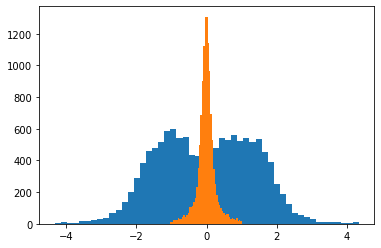

In [19]:
_=plt.hist(gt_nooutliers,bins=50)
_=plt.hist(fmri_nooutliers,bins=50)

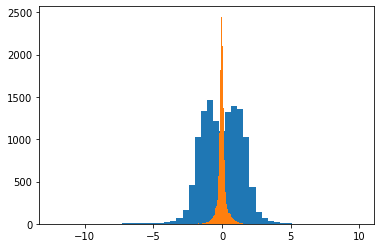

In [20]:
_=plt.hist(gt_skew,bins=50)
_=plt.hist(fmri_skew,bins=50)

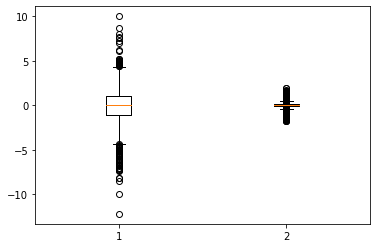

In [21]:
_ = plt.boxplot([gt_skew,fmri_skew])

In [1]:
idx = 800
gt_data = gt_norm_MZ[skew_idx].flatten()
fmri_data = fmri_norm_MZ[skew_idx].flatten()
plt.plot(gt_data+120,label="GT")
plt.plot(fmri_data,label="fMRI")
plt.legend(loc="upper right")

NameError: name 'gt_norm_MZ' is not defined

In [ ]:
# here we assume that the two distributions add
with pm.Model() as multi_noise:
    sigma1 = pm.Uniform('sigma1',0,20)
    ampl_noise = pm.Uniform('ampl_noise',0,5)
    
    fmri_observed = pm.Normal('fmri_observed',
                              mu=gt_data,
                              sigma=np.sqrt(sigma1**2+ampl_noise**2*gt_data**2), observed=fmri_data)

    posterior_2 = pm.sample()

/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ampl_noise, sigma1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7373 seconds.


In [ ]:
#pm.traceplot(posterior_2)

In [87]:
with pm.Model() as multi_noise:
    pm.summary(posterior_2)

/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
sigma1,12.309,0.009,12.293,12.325,0.0,0.0,2813.0,2813.0,2816.0,2482.0,1.0
ampl_noise,0.706,0.003,0.701,0.711,0.0,0.0,2645.0,2643.0,2646.0,2021.0,1.0


In [83]:
# now we want to see what are the contributions to the noise
# here we assume that the multiplicative noise is prop to delta_S
sig = np.mean(posterior_2['sigma1'])
amp_noise = np.mean(posterior_2['ampl_noise'])
sigma_mult = np.sqrt(np.sum((amp_noise**2)*gt_data**2)/len(gt_data))
sig_total = np.sqrt(sigma_mult**2+sig**2)
print("sigma mult:",sigma_mult)
print("sigma thermal:",sig)
print("sigma thermal normalized",sig/np.std(gt_data))
print("sigma thermal normalized error",np.std(posterior_2['sigma1'])/np.std(gt_data))
print("sigma total noise fitted:",np.sqrt(sigma_mult**2+sig**2))
print("sigma total (fmri-gt):",np.std(fmri_data-gt_data))
print("sigma GT:",np.std(gt_data))
print("signal to noise ratio:",np.std(gt_data)**2/(sigma_mult**2+sig**2))
print("sigma multi/total:",sigma_mult**2/sig_total**2)

sigma mult: 5.319601712148386
sigma thermal: 12.309340380669042
sigma thermal normalized 1.6347177432624795
sigma thermal normalized error 0.0011688685830877244
sigma total noise fitted: 13.409624267035282
sigma total (fmri-gt): 13.321727587682403
sigma GT: 7.529948476672639
signal to noise ratio: 0.3153194719902222
sigma multi/total: 0.1573711127863844


In [86]:
# same analysis for multiplicative noise prop to S
sig = np.mean(posterior_2['sigma1'])
amp_noise = np.mean(posterior_2['ampl_noise'])
sigma_mult = np.sqrt(np.sum((amp_noise**2)*(gt_mean**2)/len(gt_data)))
sig_total = np.sqrt(sigma_mult**2+sig**2)
print("sigma mult:",sigma_mult)
print("sigma thermal:",sig)
print("sigma thermal normalized",sig/np.std(gt_data))
print("sigma thermal normalized error",np.std(posterior_2['sigma1'])/np.std(gt_data))
print("sigma total noise fitted:",np.sqrt(sigma_mult**2+sig**2))
print("sigma total (fmri-gt):",np.std(fmri_data-gt_data))
print("sigma GT:",np.std(gt_data))
print("sigma fmri:",np.std(fmri_data))
print("sigma fmri/sigma GT:",np.std(fmri_data)/np.std(gt_data))
print("signal to noise ratio:",np.std(gt_mean)**2/(sigma_mult**2+sig**2))
print("sigma multi/total:",sigma_mult**2/sig_total**2)
print("sigma multi/thermal:",sigma_mult**2/sig**2)

sigma mult: 22.919602913141077
sigma thermal: 12.309340380669042
sigma thermal normalized 1.6347177432624795
sigma thermal normalized error 0.0011688685830877244
sigma total noise fitted: 26.015919324583447
sigma total (fmri-gt): 13.321727587682403
sigma GT: 7.529948476672639
sigma fmri: 14.075899575172947
sigma fmri/sigma GT: 1.8693221631966406
signal to noise ratio: 3.9994636327608015
sigma multi/total: 0.7761324183471052
sigma multi/thermal: 3.4669263526976137


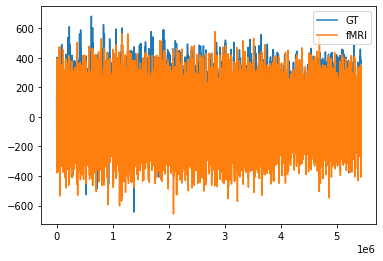

In [16]:
# lets see whether anything changes if we only take pearson positive traces
idx = 800
gt_data = gt_norm_MZ[fmri_gt_pearsonr>0].flatten()
fmri_data = fmri_norm_MZ[fmri_gt_pearsonr>0].flatten()
plt.plot(gt_data+120,label="GT")
plt.plot(fmri_data,label="fMRI")
plt.legend(loc="upper right")

In [ ]:
# here we assume that the two distributions add
with pm.Model() as multi_noise2:
    sigma1 = pm.Uniform('sigma1',0,20)
    ampl_noise = pm.Uniform('ampl_noise',0,5)
    
    fmri_observed = pm.Normal('fmri_observed',
                              mu=gt_data,
                              sigma=np.sqrt(sigma1**2+ampl_noise**2*gt_data**2), observed=fmri_data)

    posterior_3 = pm.sample()

/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ampl_noise, sigma1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7086 seconds.


In [90]:
# now we want to see what are the contributions to the noise
# here we assume that the multiplicative noise is prop to delta_S
sig = np.mean(posterior_2['sigma1'])
amp_noise = np.mean(posterior_2['ampl_noise'])
sigma_mult = np.sqrt(np.sum((amp_noise**2)*gt_data**2)/len(gt_data))
sig_total = np.sqrt(sigma_mult**2+sig**2)
print("sigma mult:",sigma_mult)
print("sigma thermal:",sig)
print("sigma thermal normalized",sig/np.std(gt_data))
print("sigma thermal normalized error",np.std(posterior_2['sigma1'])/np.std(gt_data))
print("sigma total noise fitted:",np.sqrt(sigma_mult**2+sig**2))
print("sigma total (fmri-gt):",np.std(fmri_data-gt_data))
print("sigma GT:",np.std(gt_data))
print("signal to noise ratio:",np.std(gt_data)**2/(sigma_mult**2+sig**2))
print("sigma multi/total:",sigma_mult**2/sig_total**2)

sigma mult: 5.789364280550853
sigma thermal: 12.309340380669042
sigma thermal normalized 1.502072919327683
sigma thermal normalized error 0.0010740238503834977
sigma total noise fitted: 13.602815862169406
sigma total (fmri-gt): 12.841471474892998
sigma GT: 8.194902006607386
signal to noise ratio: 0.36293586848702475
sigma multi/total: 0.18113572604126094


In [91]:
# same analysis for multiplicative noise prop to S
sig = np.mean(posterior_2['sigma1'])
amp_noise = np.mean(posterior_2['ampl_noise'])
sigma_mult = np.sqrt(np.sum((amp_noise**2)*(gt_mean**2)/len(gt_data)))
sig_total = np.sqrt(sigma_mult**2+sig**2)
print("sigma mult:",sigma_mult)
print("sigma thermal:",sig)
print("sigma thermal normalized",sig/np.std(gt_data))
print("sigma thermal normalized error",np.std(posterior_2['sigma1'])/np.std(gt_data))
print("sigma total noise fitted:",np.sqrt(sigma_mult**2+sig**2))
print("sigma total (fmri-gt):",np.std(fmri_data-gt_data))
print("sigma GT:",np.std(gt_data))
print("sigma fmri:",np.std(fmri_data))
print("sigma fmri/sigma GT:",np.std(fmri_data)/np.std(gt_data))
print("signal to noise ratio:",np.std(gt_mean)**2/(sigma_mult**2+sig**2))
print("sigma multi/total:",sigma_mult**2/sig_total**2)
print("sigma multi/thermal:",sigma_mult**2/sig**2)

sigma mult: 27.345978333036165
sigma thermal: 12.309340380669042
sigma thermal normalized 1.502072919327683
sigma thermal normalized error 0.0010740238503834977
sigma total noise fitted: 29.988704400124604
sigma total (fmri-gt): 12.841471474892998
sigma GT: 8.194902006607386
sigma fmri: 14.738122270047977
sigma fmri/sigma GT: 1.798450092284804
signal to noise ratio: 3.009987552968379
sigma multi/total: 0.8315177493380034
sigma multi/thermal: 4.935343314033511


In [97]:
with pm.Model() as multi_noise2:
    display(pm.summary(posterior_3))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
sigma1,12.111,0.010,12.093,12.130,0.0,0.0,2802.0,2802.0,2818.0,2409.0,1.0
ampl_noise,0.533,0.003,0.528,0.539,0.0,0.0,2873.0,2873.0,2902.0,2428.0,1.0
